# 꿈꾸는 인공지능 13강
* https://www.youtube.com/watch?v=TTqO__t2Vsc&t=199s
* 신경 스타일 전이
* 참고문헌 
  * A Neural Algorithm of Artistic Style : https://arxiv.org/pdf/1508.06576.pdf
  * Texture Synthesis Using Convolutional Neural
Networks : https://arxiv.org/pdf/1505.07376.pdf

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# 원본 텍스처 이미지 불러오기 및 픽셀 정규화
 

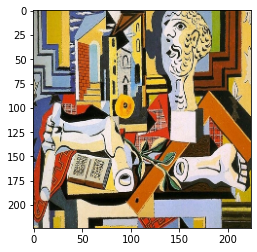

In [ ]:
style_image = plt.imread('/content/sample_data/Picasso.jpg')

style_image = cv2.resize(style_image, dsize=(224,224))
style_image = style_image / 255.0

plt.imshow(style_image)

# 타겟 텍스처 생성 
 * 위에서 불러온 이미지와 같은 차원을 갖는 랜덤 노이즈 생성
 * tf.random.uniform() : 균등분포로 부터 난수값을 반환, 즉 모든 픽셀에 대하여 0~1 사이의 난수값을 반환

tf.Tensor([0.03265905 0.6192579  0.8215898 ], shape=(3,), dtype=float32)


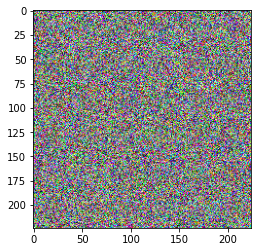

In [ ]:
target_image = tf.random.uniform(style_image.shape)
#부분 확인 (타겟 텍스처의 첫 번째 픽셀(0,0)의 값 출력)
print(target_image[0,0,:])
plt.imshow(target_image)

# 특징추출기 VGG19 불러오기 
 * include_top : 전체 신경망을 불러올 필요없음. 마지막 Dense 레이어 제외한 나머지 레이어를 불러옴
 *  weights : 가중치가 학습된 데이터세트 

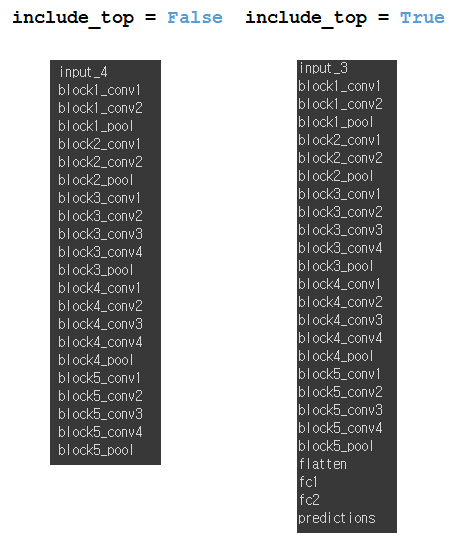


In [ ]:
#내장된 VGG19 불러오기 
from tensorflow.keras.applications import VGG19
#preprocess_input() : 
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top = False,  #vgg에 속에있는 레이어 확인 
                                  #(마지막 dense 레이어는 불러오지 않음)

            weights = 'imagenet') # 가중치는 imagenet에서 사전학습
#각 레이어의 이름 확인 
for layer in vgg.layers :
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


# Gram Matrix 수행 사전준비

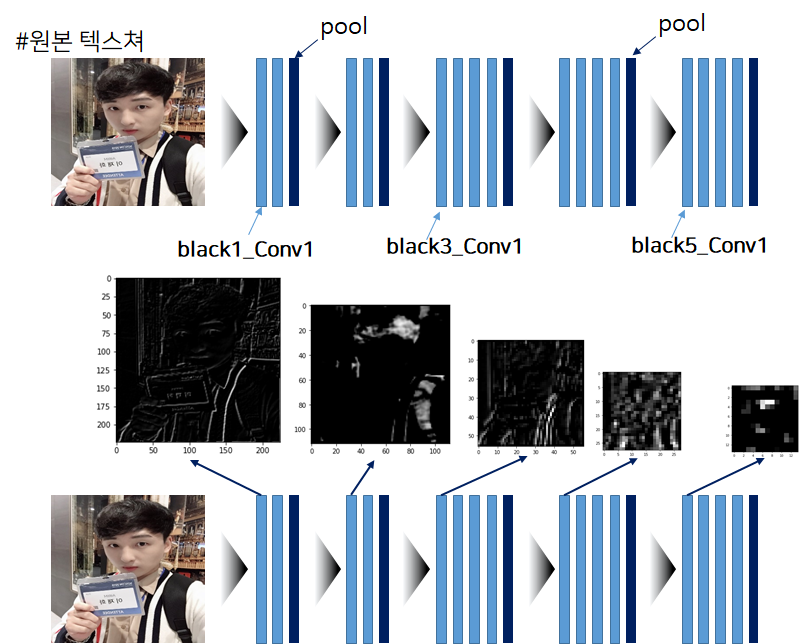

In [ ]:
# Gram matrix 를 수행하기 위해 각 block마다의 첫 번째 conv1를 출력으로 하는 새로운 모델을 만든다.
# 네트워크 전체로 볼 때, 다섯개의 컨볼루션 레이어를 고르게 선택 및 이름 저장 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

#VGG19 layers freeze 
vgg.trainable = False

#각 블럭마다의 첫번째 conv1을 빼내 출력으로 하는 새로운 모델 생성 준비.
outputs = [vgg.get_layer(name).output for name in style_layers]
#outputs → 
'''[<tf.Tensor 'block1_conv1/Relu:0' shape=(None, None, None, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(None, None, None, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu:0' shape=(None, None, None, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu:0' shape=(None, None, None, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1/Relu:0' shape=(None, None, None, 512) dtype=float32>]'''
 
#이미지를 입력하면 다섯개의 레이어에서 출력되는 특징 추출값을 얻을 수 있는 모델
model = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

# Gram_matrix 수행 함수 제작 
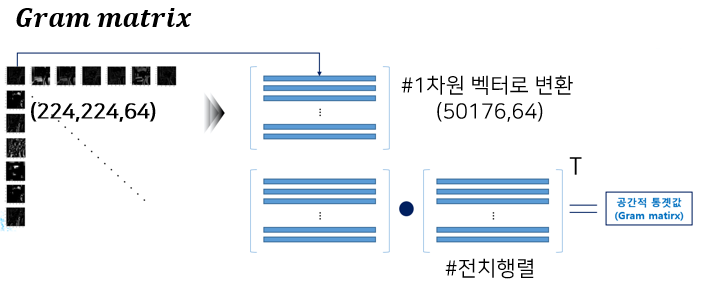

In [ ]:
def gram_matrix(input_tensor):
  # [1,224,224,64] 중 64 즉, 채널값 저장
  channels = int(input_tensor.shape[-1])
  
  # tensor를 받아서, 채널 제외, 1차원 벡터로 변환 [1,224,224,64] → [50176,64]
  a = tf.reshape(tensor=input_tensor, shape = [-1, channels] ) # [-1, 64] 중 -1의 역할은 고정된 차원을 생성, 즉 마지막에 64 차원(채널) 생성 
  
  #a의 첫 번째 차원값을 저장 
  n = tf.shape(a)[0]  
  # n = 50176

  #행렬곱 수행(a,a, transpose_a = true (a를 전치행렬))
  #[64,50176]*[50176,64] = [64,64]
  gram = tf.matmul(a,a,transpose_a=True)
  
  # 일종의 정규화(하지 않게되면 앞쪽에 오는 레이어일수록 특징 추출값의 이미지가 크기 때문에 Gram_matrix값도 커지게 되므로 큰 영향을 주게됨)
  # tf.cast() 타입 변화
  return gram / tf.cast(n, tf.float32)

#원본텍스처 준비

In [ ]:
style_image = plt.imread('/content/sample_data/Picasso.jpg')

style_image = cv2.resize(style_image, dsize=(224,224))
style_image = style_image / 255.0

#배치 차원 생성 (224,224,3) → (1,224,224,3)
#신경망 입력 조건
style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis=0)

#preprocess_input() : VGG-19에서 이미지를 전처리 해주는 함수, mode = 'caffe'
#이미지 배치를 인코딩하는 텐서 또는 Numpy 배열 사전 처리. 
#이미지를 RGB에서 BGR로 변환 한 다음 스케일링없이 ImageNet 데이터 세트와 관련하여 각 색상 채널의 중심을 제로화합니다.
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/imagenet_utils/preprocess_input?hl=ko-KR 

'''@keras_export('keras.applications.vgg19.preprocess_input')
def preprocess_input(x, data_format=None):
  return imagenet_utils.preprocess_input(
      x, data_format=data_format, mode='caffe')'''

# style_output은 다섯 레이어를 통과한 특징 추출값으로 구성 
#0~255의 픽셀값이 들어온다는 가정했기에 값에 255.0을 곱해준다.
#앞서 설정한 model에 원본 이미지 넣어주기 
style_output = model(inputs = preprocess_input(style_batch * 255.0))

# style_output 중간 결과 확인 

In [ ]:
style_output[0]

<tf.Tensor: shape=(1, 224, 224, 64), dtype=float32, numpy=
array([[[[  0.       ,  15.962008 ,   9.24568  , ...,   0.       ,
           11.337623 ,   0.       ],
         [  0.       ,  27.401634 ,  35.087967 , ...,   0.       ,
           89.71949  ,  65.00657  ],
         [  0.       ,  24.705824 ,  29.494417 , ...,   0.       ,
           73.264984 ,  46.751328 ],
         ...,
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            7.2132654,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            6.6778727,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
           20.117144 ,   0.       ]],

        [[  0.       ,  23.422838 ,  13.044338 , ...,   0.       ,
            0.       ,   0.       ],
         [ 48.922123 ,  33.136124 ,  35.760475 , ...,   0.       ,
            0.       ,  32.189453 ],
         [  9.155661 ,  30.336489 ,  25.371677 , ...,   0.       ,
            0.       ,   0

# 원본 텍스처의 첫 번째 특징 추출값 확인 (style_output)


(1, 224, 224, 64)


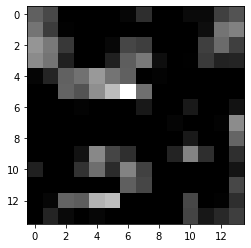

In [ ]:
print(style_output[0].shape)
#시각화를 하려면 2차원으로 맞춰야 하기때문에 tf.squeeze()를 사용, axis = 0 을 적용하여 맨 앞의 1차원 제거)
#(1,224,224) → (224,224)
plt.imshow(tf.squeeze(style_output[4][:,:,:,0],
                      axis = 0), cmap ='gray')

# tf.squeeze() 적용 전 후 차이 

In [ ]:
tf.squeeze(style_output[0][:,:,:,0],axis = 0)

<tf.Tensor: shape=(224, 224), dtype=float32, numpy=
array([[  0.       ,   0.       ,   0.       , ...,  19.460894 ,
         50.000355 ,   0.       ],
       [  0.       ,  12.456318 ,  13.003512 , ...,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   7.970782 ,   6.006915 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [  0.       ,   0.       ,   0.       , ...,   0.       ,
          0.       , 161.66193  ],
       [  0.       ,   0.       ,   0.       , ...,   4.9293466,
          0.       , 161.47275  ],
       [ 25.16572  ,  70.86617  , 121.67816  , ..., 155.29668  ,
        147.36372  , 236.53908  ]], dtype=float32)>

In [ ]:
style_output[0][:,:,:,0]

<tf.Tensor: shape=(1, 224, 224), dtype=float32, numpy=
array([[[  0.       ,   0.       ,   0.       , ...,  19.460897 ,
          50.00036  ,   0.       ],
        [  0.       ,  12.456299 ,  13.003493 , ...,   0.       ,
           0.       ,   0.       ],
        [  0.       ,   7.970759 ,   6.006894 , ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [  0.       ,   0.       ,   0.       , ...,   0.       ,
           0.       , 161.66196  ],
        [  0.       ,   0.       ,   0.       , ...,   4.9293294,
           0.       , 161.47276  ],
        [ 25.16572  ,  70.866165 , 121.678116 , ..., 155.29669  ,
         147.36372  , 236.53908  ]]], dtype=float32)>

# Gram_Matrix 수행 결과값들의 분포 
 * 현재 Gram matrix 값은 레이어마다 다르고 최댓값도 차이가 크게 차이가 남. 각 레이어에서 계산되는 Gram matrix 값에 가중치를 곱해주는 방법으로 특정한 레이어가 너무 큰 영향을 끼치지 못하도록 제어도 가능하지만 우선 그냥 수행

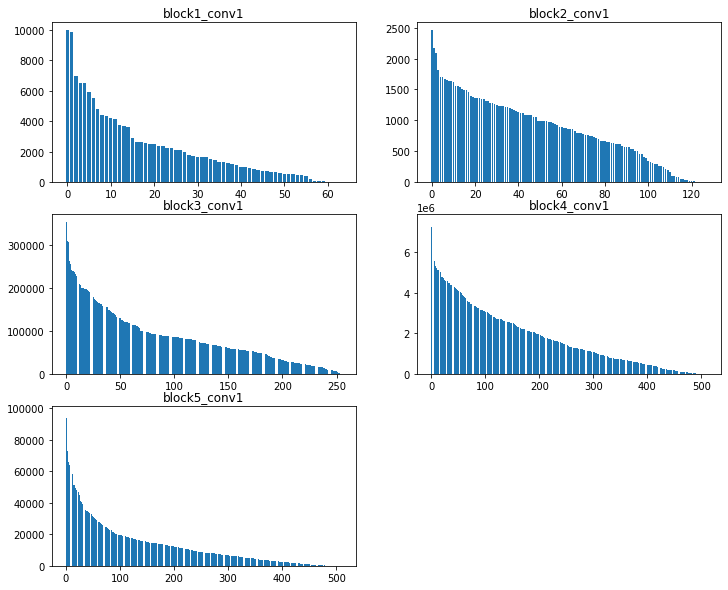

In [ ]:
import numpy as np

#각 블럭마다의 conv1을 Gram_matrix()에 적용
style_outputs = [gram_matrix(out) for out in style_output]

plt.figure(figsize=(12,10))

for c in range(5):
  plt.subplot(3,2,c+1)
  #Gram_matrix 값을 도출하여 리스트 형태로 만들어 정렬
  array = sorted(style_outputs[c].numpy()[0].tolist())
  #내림차순
  array = array[::-1]
  #bar출력 
  plt.bar(range(style_outputs[c].shape[0]), array)
  #style_layers에 저장된 이름들 순차적 출력 
  plt.title(style_layers[c])

plt.show()

# 타깃 텍스처에서 Gram matrix 구하는 함수 

In [ ]:
def get_outputs(image):
  #배치 차원 추가
    image_batch = tf.expand_dims(image, axis=0)
  #각 값에 255를 곱해주고, preprocess_input을 통한 전처리후 model에 할당 
    output = model(preprocess_input(image_batch * 255.0))
  #모델 통과 후 Gram_matrix 값 도출 
    outputs = [gram_matrix(out) for out in output]
    return outputs

# 타깃 텍스쳐와 원본 텍스쳐의 Gram matrix값에 대한 MSE 도출
* tf.reduce_mean() : 전체 평균을 구하되, 모든 차원을 제거하고 단 하나의 차원(스칼라)만을 반환한다. 

In [ ]:
def get_loss(outputs, style_outputs):
    return tf.reduce_sum([tf.reduce_mean((o-s)**2) for o,s in zip(outputs, style_outputs)])

# 이미지 픽셀 컬러값 0 ~ 1 값 고정 
 * tf.clip_by_value() : 최소값과 최대값을 정해 넘어가는 값을 잘라주는 함수

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# tf.function과 GradientTape을 활용한 이미지 업데이트 함수 정의 
 * @장식자(decorator) 활용 : 기존의 코드에 간편하게 기능을 추가
 * tf.function() : 성능을 올려주는 새로운 함수
 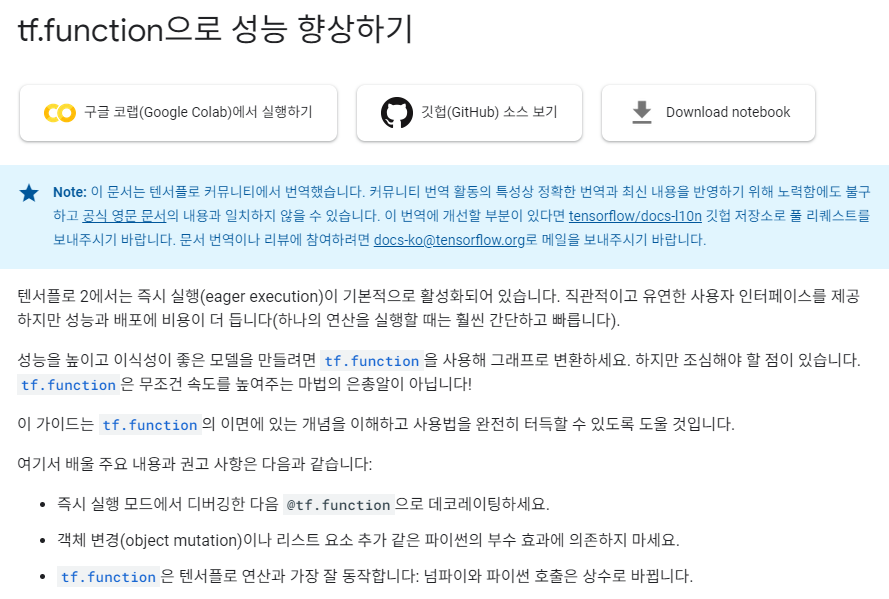 

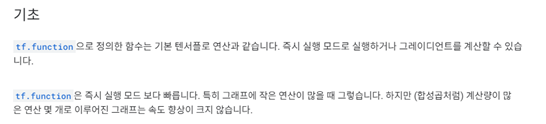

# GradientTape
* 계산에 관계되는 모든 변수와 연산을 추적
* 보통 with()과 함께 사용 

In [ ]:
#경사하강법 최적화 수행 Adam
opt = tf.optimizers.Adam(learning_rate=0.2)

#장식자를 활용 
@tf.function()

def train_step(image):
  #보통 GradientTape()은 with와 함께 사용 
    with tf.GradientTape() as tape:
        #Gram_matirx 결과 출력
        outputs = get_outputs(image)
        #원본과 타깃 텍스쳐간의 loss(mse)산출
        loss = get_loss(outputs, style_outputs)

    #역전파 과정 
    #tape의 gradient()를 사용하여 입력값과 손실사이의 손실 기울기를 구해줍니다.  
    grad = tape.gradient(loss, image)
    #grad에 옵티마이저를 적용한 학습을 통해 image를 개선시킨다.
    opt.apply_gradients([(grad, image)])
    #개선된 image를 마지막으로 clip 함수를 적용시켜 새로운 image를 생성(assing) 
    image.assign(clip_0_1(image))

# 학습 수행


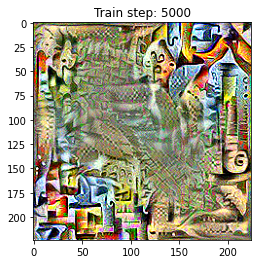

Total time: 66.5


In [ ]:
import IPython.display as display #이전 텍스처를 지우고 새로운 텍스처 생성 
import time  # 실행시간 추적 
import imageio # 합성된 텍스쳐 저장 

start = time.time() #현재 시간을 담아준다 

image = tf.Variable(target_image) #텐서플로우의 그래프 연산을 위한 변수화 

epochs = 50     # 에폭수
steps_per_epoch = 100 #한번의 에폭을 위한 누적 에폭수

step = 0 #스텝 수 

#에폭 수 만큼 반복 
for n in range(epochs): 
  #한번의 에폭을 수행하기 위한 누적 에폭수 반복
  for m in range(steps_per_epoch):
    step += 1
    train_step(image) #train_step 함수 실행하여 타켓 텍스쳐(image) 학습 

   # 저장해주는 조건식 (0 부터 5단위 혹은 49번째)
  if n % 5 == 0 or n == epochs -1 :
    #저장해주기 / '파일명.png'
    imageio.imwrite('style_epoch_{0}.png'.format(n), image.read_value().numpy())
  #100번의 에폭이 끝나면 지워준다.
  display.clear_output(wait = True)
  #저장된 이미지 출력
  plt.imshow(image.read_value())
  #train step 출력
  plt.title('Train step: {}'.format(step))
  plt.show()

#끝나는 시간 기록
end = time.time()
#end-start 걸린 시간 출력 
print("Total time: {:.1f}".format(end-start))

# Variation loss 함수 정의
 * 앞서 출력한 결과는 자글자글한 노이즈가 포함되어 있다. (개선이 필요)
 * 일반적인 전체 손실에 variation loss를 추가할 수 있습니다.  
  * variation loss : 어떤 픽셀과 바로 옆에 인접한 픽셀의 차이. 
  ######  이 차이가 작을 수록 매끄럽게 보인다.

  

In [ ]:
# 이 함수는 입력된 image의 x축 방향과 y축 방향의 차이를 구합니다. 
# (224,224,3) →(224, 223, 3), (223,224,3) 각각 x와 y방향으로 1픽셀씩 작은 이미지  
def high_pass_x_y(image): # 이미지를 입력으로 받게되면
  #[ ,입력,출력] 
    x_var = image[:,1:,:] - image[:,:-1,:]
    y_var = image[1:,:,:] - image[:-1,:,:]
    return x_var, y_var #차이를 반환

#x축 y축 방향의 차이를 제곱해서 평균을 낸 다음 반환
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

# Variation loss의 필요성
* 현재 

In [ ]:
print('타겟 텍스쳐 :', total_variation_loss(image.read_value()))
print('랜덤 노이즈 :', total_variation_loss(tf.random.uniform(style_image.shape)))
print('원본 텍스쳐 :', total_variation_loss(style_image))

타겟 텍스쳐 : tf.Tensor(0.118929744, shape=(), dtype=float32)
랜덤 노이즈 : tf.Tensor(0.33199492, shape=(), dtype=float32)
원본 텍스쳐 : tf.Tensor(0.0258512507262643, shape=(), dtype=float64)


# Variation loss를 추가한 텍스터 합성 

In [ ]:
#이 두 가중치는 정답이 없다.(예술에 정답은 존재하지 않는다.)
total_variation_weight = 1e9
style_weight = 1e-1

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        #새롭게 추가 
        #loss' = loss * 새로운 가중치  
        loss = style_weight * get_loss(outputs, style_outputs)
        #loss' += 새로운 total_variation_weight 가중치 * 새롭게 구한 total_variation_loss 
        loss += total_variation_weight * total_variation_loss(image)

    #가중치 갱신 
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

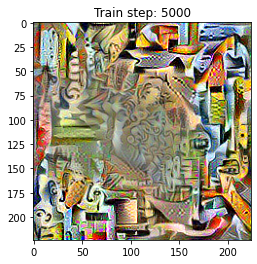

Total time: 66.0


In [ ]:
start = time.time()

target_image = tf.random.uniform(style_image.shape)
image = tf.Variable(target_image)

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_variation_epoch_{0}.png'.format(n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

# 신경스타일 전이 

* 참고문헌 : https://arxiv. /pdf/1508.06576.pdf

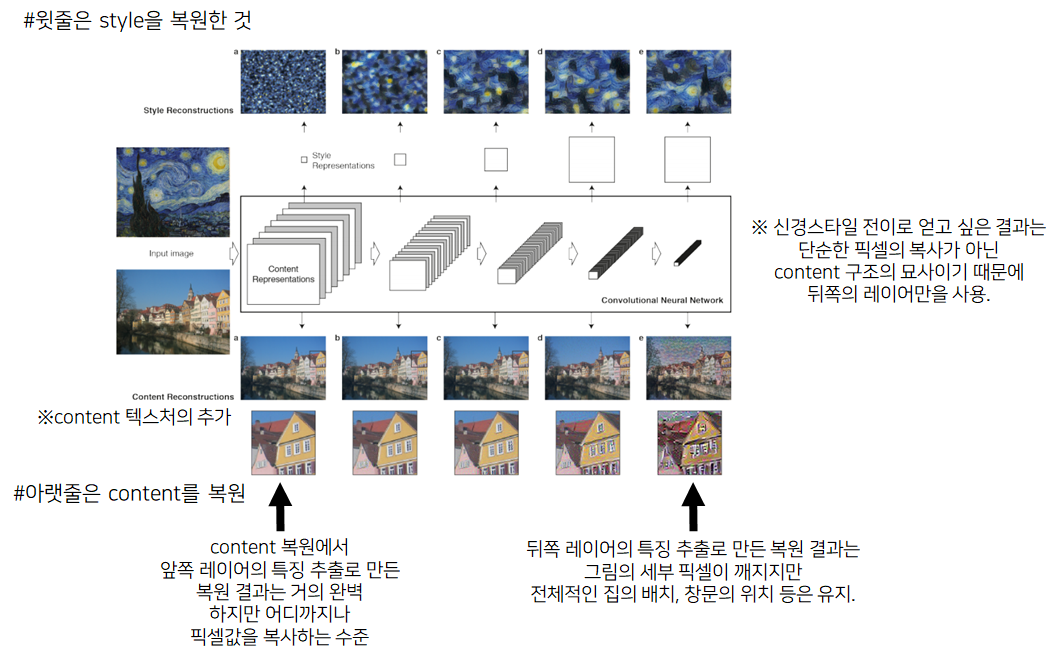

# 신경스타일 전이 프로세스 
* 이전 과정에서 content 텍스처의 추가
 * 타깃 텍스처를 만들기 위해서 style 텍스처와 Gram matrix의 MSE를 구하고, 
  content 텍스처와는 픽셀 값의 차이인 MSE를 구함. 
 * content loss를 위해서는 뒤쪽의 한 개 레이어에서 얻은 특징 추출값만 사용.

 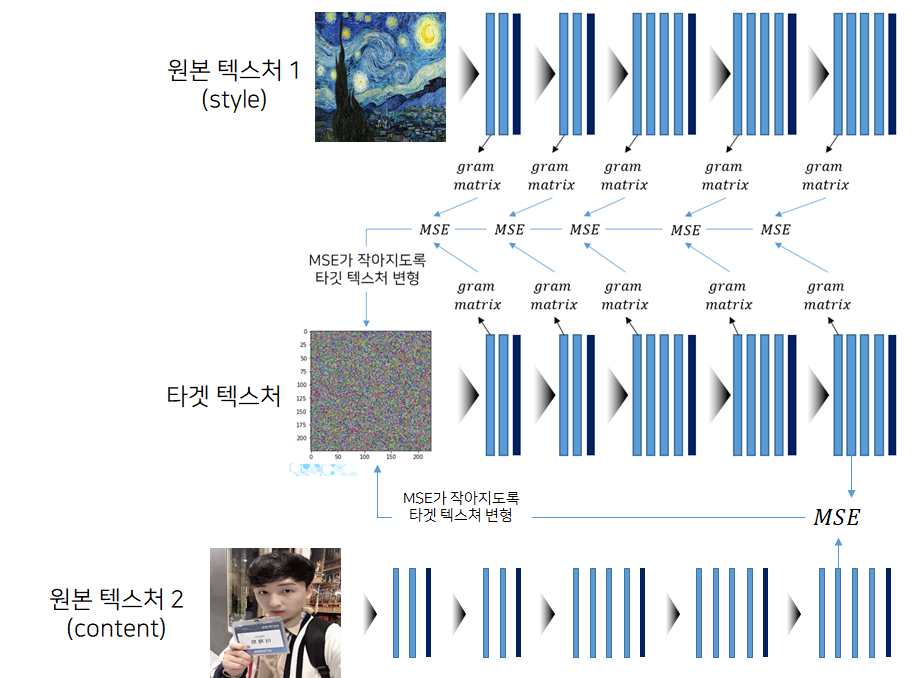

조정 전 픽셀 :  (960, 720, 3)


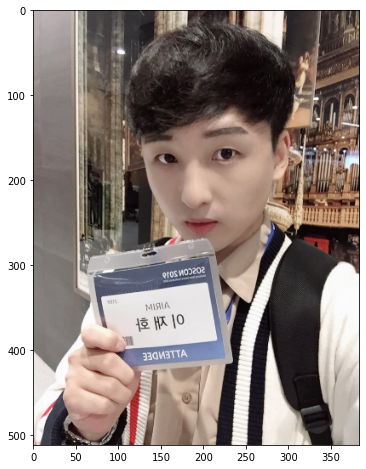

조정 후 픽셀 :  (512, 384, 3)


In [ ]:
#이미지 불러오기 (960, 760)
content_image = plt.imread('/content/sample_data/KakaoTalk_20191031_100127733.jpg')
print("조정 전 픽셀 : ", content_image.shape)

#최대치 픽셀 설정 (VGG19는 큰 이미지를 받을 수 있지만 어느정도 퍼포먼스를 유지하기 위해 적당한 크기 설정)
max_dim = 512

#가로 세로중 더 큰 픽셀 탐색 후 max_dim으로 변경 
long_dim = max(content_image.shape[:-1])

#long_dim을 활용한 scale값 도출 
scale = max_dim/long_dim

#가로 세로 이미지 리사이즈
new_height = int(content_image.shape[0] * scale)
new_width = int(content_image.shape[1] * scale)

#cv2를 활용한 크기 변경 
content_image = cv2.resize(content_image, dsize = (new_width, new_height))
#정규화 
content_image = content_image / 255.0

plt.figure(figsize=(8,8))
plt.imshow(content_image)
plt.show()


print("조정 후 픽셀 : ", content_image.shape)

In [ ]:
# 자료형 전환 (효율적 메모리 사용)
content_batch = content_image.astype('float32')

In [ ]:
#차원 추가
content_batch = tf.expand_dims(content_batch, axis=0)
content_batch.shape

TensorShape([1, 512, 384, 3])

In [ ]:
#content loss를 위해서는 뒤쪽의 한 개 레이어에서 얻은 특징 추출값만을 사용
content_layers = ['block5_conv2']

In [ ]:
# Vgg19  동결 
# vgg = VGG19(include_top = False, weights = 'imagenet')
vgg.trainable = False

In [ ]:
#출력 레이어 설정 - #block5_conv2
outputs = [vgg.get_layer(name).output for name in content_layers]
outputs

[<tf.Tensor 'block5_conv2/Relu:0' shape=(None, None, None, 512) dtype=float32>]

In [ ]:
#모델 재구축 
model_content = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

In [ ]:
model_content.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [ ]:
# preprocess_input() : 이미지 전처리 함수 
# model_content 모델에 이미지 삽입
content_output = model_content(inputs = preprocess_input(content_batch * 255.0))

In [ ]:
model_content

In [ ]:
# content전용의 output 함수 정의 
def get_content_output(image):
    image_batch = tf.expand_dims(image, axis=0)
    output = model_content(preprocess_input(image_batch * 255.0))
    return output

# content전용의 loss 함수 정의 
def get_content_loss(image, content_output):
    return tf.reduce_sum(tf.reduce_mean(image-content_output)**2)

In [ ]:
#style_image 준비
style_image = plt.imread('/content/sample_data/Screenshot.jpg')

style_image = cv2.resize(style_image, dsize=(224,224))
style_image = style_image / 255.0

style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis=0)

style_output = model(inputs = preprocess_input(style_batch * 255.0))

style_outputs = [gram_matrix(out) for out in style_output]

In [ ]:
#하이퍼 파라미터 설정 ('lr'이 높을수록 더 묘사를 잘함)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#새로운 가중치 생성
total_variation_weight = 1e9
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        output2 = get_content_output(image)
        loss = style_weight * get_loss(outputs, style_outputs)
        loss += content_weight * get_content_loss(output2, content_output)
        #새로운 가중치의 등장으로 loss에 추가
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

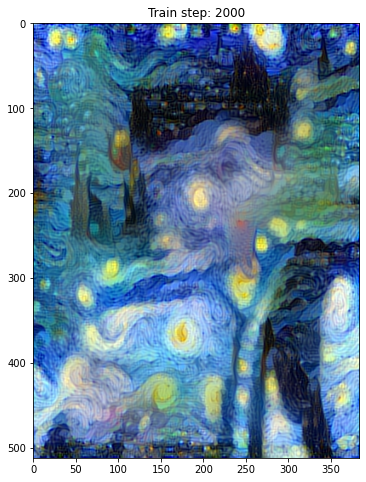

Total time: 126.4


In [ ]:
start = time.time()

image = tf.Variable(content_image.astype('float32'))

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_{0}_content_{1}_transfer_epoch_{2}.png'.format(style_weight, content_weight, n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.figure(figsize=(8,8))
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))